In [2]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import multiprocessing
import math
import csv

In [3]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    while not bool(slices) or slices[-1][-1] != (file_entries[-1]):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

def to_numpy_helper(files, partitions, index, result):
    data = []
    for i in range(partitions[index][0], partitions[index][2] + 1):
        data.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=partitions[index][1] if i == partitions[index][0] else None,
                              entry_stop=partitions[index][3] if i == partitions[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data)))
    
def to_numpy(path, n_processes):
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))]
    partitions = partition(files, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=to_numpy_helper, args=[files, partitions, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        
    return np.concatenate(tuple(result))

In [4]:
path = "../data/64_files/"

In [5]:
# data = to_numpy(path, 64)

# file = uproot.recreate("tree/mass.root")
# file["CandidateTree"] = {"candidate_vMass" : data}

# data = uproot.open("tree/mass.root:CandidateTree").arrays(library="np")["candidate_vMass"]

# plt.figure(figsize=(15, 5))
# plt.hist(data, bins=200)
# plt.show()

In [6]:
file = ROOT.TFile("filtered_data/mass.root")
tree = file.Get("CandidateTree")
tree.Print()

******************************************************************************
*Tree    :CandidateTree:                                                        *
*Entries :   189667 : Total =         1518315 bytes  File  Size =     661942 *
*        :          : Tree compression factor =   2.30                       *
******************************************************************************
*Br    0 :candidate_vMass : candidate_vMass/D                                *
*Entries :   189667 : Total  Size=    1517960 bytes  File Size  =     661054 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   2.30     *
*............................................................................*


In [7]:
mass = ROOT.RooRealVar("candidate_vMass", "candidate_vMass", 5.33, 5.4)
data = ROOT.RooDataSet("data", "data", mass, ROOT.RooFit.Import(tree))
data.Print()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

RooDataSet::data[candidate_vMass] = 189667 entries


In [8]:
c = ROOT.TCanvas("canvas", "canvas", 1500, 800)

In [9]:
mass_frame = mass.frame()
data.plotOn(mass_frame)
mass_frame.Draw()

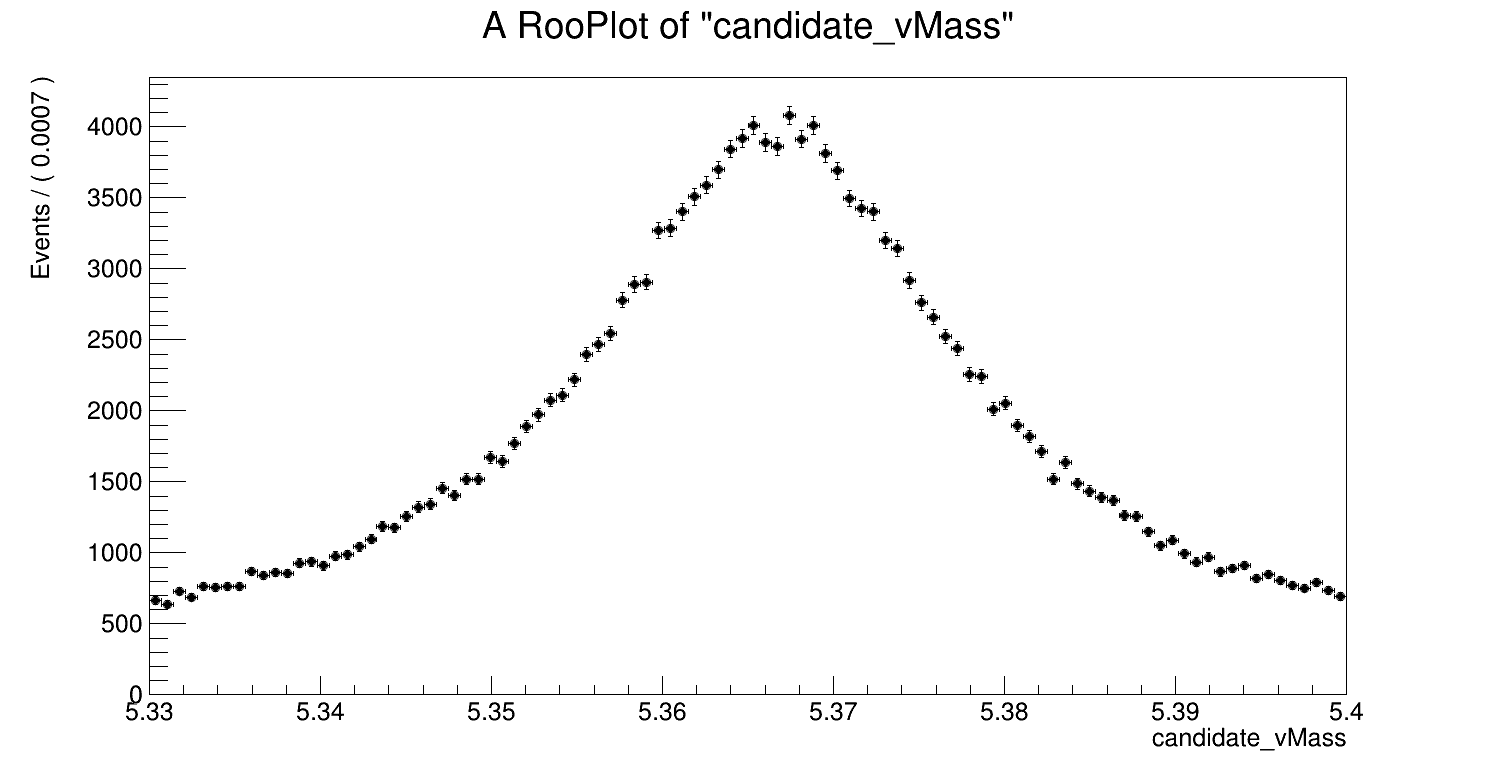

In [10]:
c.Draw()

In [11]:
mean = ROOT.RooRealVar("mean", "mean of gaussians", 5.36, 5.2, 5.4)
sigma = ROOT.RooRealVar("sigma", "width", 0.1, 0.001, 0.2)
signal = ROOT.RooGaussian("signal", "signal", mass, mean, sigma)

In [12]:
a0 = ROOT.RooRealVar("a0", "a0", 0.5, 0.0, 1.0)
a1 = ROOT.RooRealVar("a1", "a1", -0.2, 0.0, 1.0)
background = ROOT.RooChebychev("bkg", "Background", mass, ROOT.RooArgList(a0, a1))

In [13]:
bkgfrac = ROOT.RooRealVar("bkgfrac", "fraction of background", 0.5, 0.0, 1.0)
model = ROOT.RooAddPdf("model", "g+cheb", ROOT.RooArgList(background, signal), ROOT.RooArgList(bkgfrac))

In [16]:
r_full = model.fitTo(data, ROOT.RooFit.NumCPU(8))

TypeError: none of the 2 overloaded methods succeeded. Full details:
  RooFitResult* RooAbsPdf::fitTo(RooAbsData& data, const RooLinkedList& cmdList) =>
    TypeError: could not convert argument 2
  RooFitResult* RooAbsPdf::fitTo(RooAbsData& data, const RooCmdArg& arg1 = RooCmdArg::none(), const RooCmdArg& arg2 = RooCmdArg::none(), const RooCmdArg& arg3 = RooCmdArg::none(), const RooCmdArg& arg4 = RooCmdArg::none(), const RooCmdArg& arg5 = RooCmdArg::none(), const RooCmdArg& arg6 = RooCmdArg::none(), const RooCmdArg& arg7 = RooCmdArg::none(), const RooCmdArg& arg8 = RooCmdArg::none()) =>
    KeyboardInterrupt: 

 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           1.39978e-09  9.27966e-04    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 BROUGHT BACK INSIDE LIMITS.
     2 a1           5.09364e-09  9.16447e-04    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 BROUGHT BACK INSIDE LIMITS.
     3 bkgfrac      4.06455e-01  3.57820e-03    0.00000e+00  1.00000e+00
     4 mean         5.36646e+00  5.03085e-05    5.20000e+00  5.40000e+00
     5 sigma        1.04198e-02  6.15155e-05    1.00000e-03  2.00000e-01
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           1
 **********
 *****

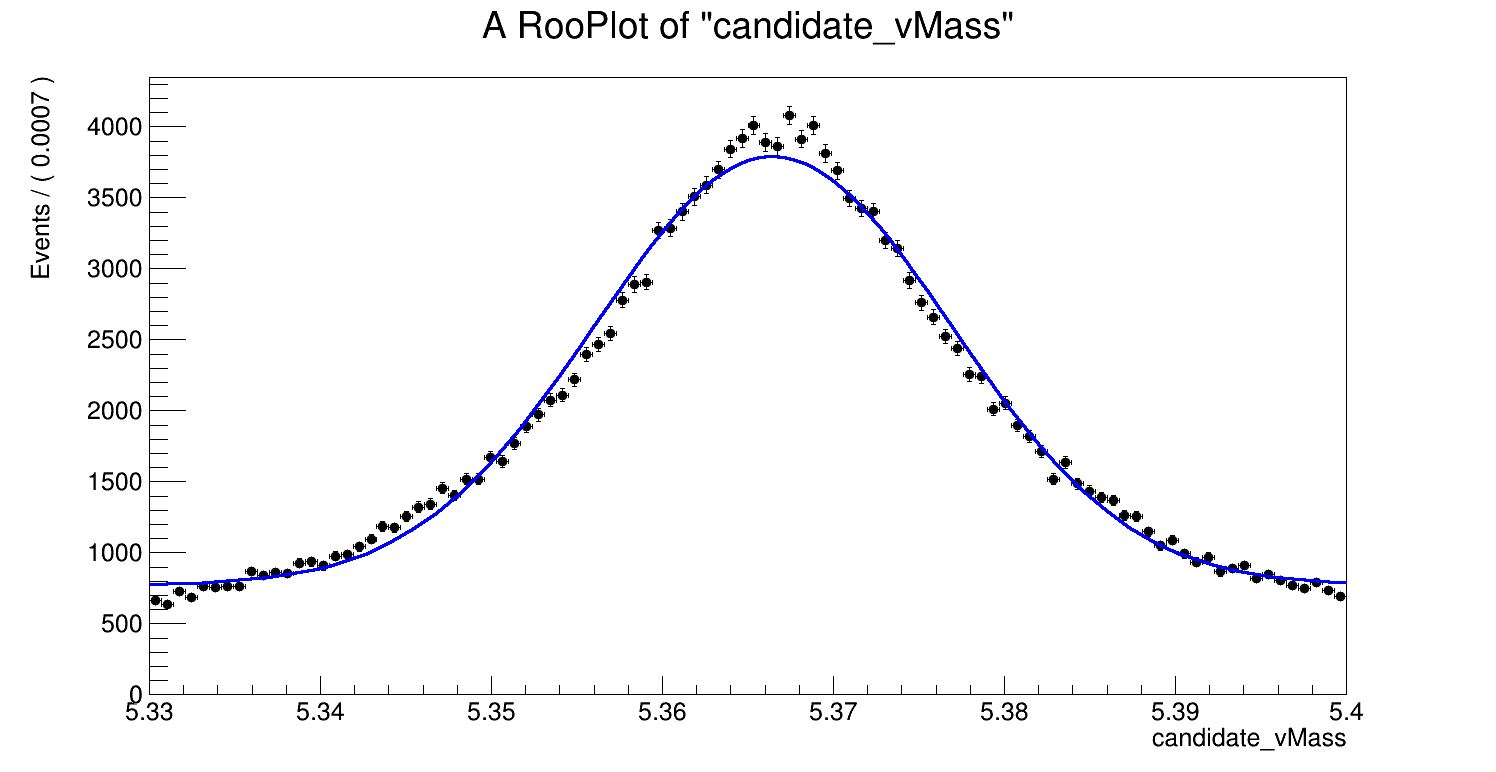

In [17]:
data.plotOn(mass_frame)
model.plotOn(mass_frame)
mass_frame.Draw()
c.Draw()